In [1]:
import torch
import torchvision
import numpy as np
import os.path as osp
import os
import time
import pandas as pd

In [2]:
CUDA = torch.cuda.is_available()
CUDA

False

In [3]:
# GLOBALS
# vot_path = "../../../vot2016/"
vot_path = "/home/zabulskyy/data/vot2016/"
yolo_pred_path = "../yolo_predictions/extended"
# yolo_pred_path = "/mnt/sshfs/YOLO-tracker/yolo_predictions/extended"

# coefficents of the parameters for computing energy
crit_vals = {
    "iou": 1,
    "cc": 1,               # class_correspondence
    "id": 1,               # initial dist 
    "vd": 1                # vector dist
}

classes = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
['blanket', 'bolt2', 'traffic', 'ball1', 'leaves', 'pedestrian1', 'singer3', 'helicopter', 'godfather', 'soccer1', 'book', 'tunnel', 'gymnastics1', 'basketball', 'birds1', 'car1', 'ball2', 'birds2', 'motocross1', 'bmx', 'gymnastics2', 'fish3', 'motocross2', 'soccer2', 'octopus', 'fernando', 'shaking', 'crossing', 'singer2', 'soldier', 'pedestrian2', 'nature', 'butterfly', 'road', 'iceskater2', 'sphere', 'fish2', 'graduate', 'marching', 'rabbit', 'car2', 'matrix', 'girl', 'tiger', 'gymnastics4', 'wiper', 'racing', 'dinosaur', 'bolt1', 'hand', 'handball1', 'bag', 'sheep', 'iceskater1', 'fish1', 'singer1', 'gymnastics3', 'fish4', 'glove', 'handball2']

print(classes)

dist = torch.nn.modules.PairwiseDistance()

vot_classes = [x for x in os.listdir(vot_path) if not x.endswith(".txt")]

print(vot_classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
['blanket', 'bolt2', 'traffic', 'ball1', 'leaves', 'pedestrian1', 'singer3', 'helicopter', 'godfather', 'soccer1', 'book', 'tunnel', '

In [4]:
def read_csv(file):
    with open(file, 'r') as file:
        l = file.read().split("\n")
        l.pop(-1)
        l = [[float(x) for x in y.split(",")[:-1]] for y in l]   
        return torch.tensor(l)
    

In [5]:
cm = read_csv("correlations.csv")  # correlation matrix

In [7]:
p, i = torch.sort(cm[2])
p, i = reversed(p), reversed(i)
table = [[classes[i[k]], float(p[k])] for k in range(len(cm[2]))]
pd.DataFrame(table, columns=["class", "correlation"])

,class,correlation
0,car,1.000000
1,truck,0.231147
2,toaster,0.017915
3,boat,0.001517
4,donut,0.001507
5,mouse,-0.000086
6,bus,-0.000256
7,bowl,-0.000798
8,fork,-0.001966
9,cell phone,-0.002041


In [7]:
def dist2(box1, box2):
    # euclidean distance between two boxes
    x11, y11, x12, y12 = box1[1:5] if len(box1) != 4 else box1[:]
    x21, y21, x22, y22 = box2[1:5] if len(box2) != 4 else box2[:]
    x1, y1 = (x11 + x12) / 2, (y11 + y12) / 2
    x2, y2 = (x21 + x22) / 2, (y21 + y22) / 2
    X = (x1 - x2) ** 2
    Y = (y1 - y2) ** 2
    res = float((X + Y) ** 0.5)
    return res

def the_closest(box_to_compare, boxes):
    # returns the closest box and its index
    m, i = np.infty, 0
    for n, box in enumerate(boxes):
        d = dist2(box, box_to_compare)
        if d < m:
            m = float(d)
            i = n
    return boxes[i], i

In [8]:
def iou(boxA, boxB):
    # IoU between two boxes
    boxA = boxA[1:5] if len(boxA) != 4 else boxA
    boxB = boxB[1:5] if len(boxB) != 4 else boxB

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    res = interArea / float(boxAArea + boxBArea - interArea)
    return res

def the_most_iou(box_to_compare, boxes):
    # returns the box with greatest IoU and its index
    M, i = 0, 0
    for n, box in enumerate(boxes):
        v = iou(box, box_to_compare)
        if v > M:
            M = float(v)
            i = n
    return boxes[i], i

In [9]:
def generate_subframes(row1, row2, width):
    frame1, frame2 = int(row1[0]), int(row2[0])
    diff = frame1 - frame2
    if diff == 1:
        return None
    result = torch.zeros((frame2 - frame1 - 1, width))
    # result[:, -1] = row1[-1]
    step = (row1 - row2) / diff
    for frame_n in range(frame2 - frame1 - 1):
        result[frame_n] = row1 + (step) * (frame_n + 1)
    return result

In [10]:
def merge_frames(*rows):
    result = torch.zeros((1, 8))
    n = len(rows)
    for row in rows:
        result += row
    return result / n

In [11]:
def fill_first(tensor):
    FIRST = tensor[0]
    for i in range(int(FIRST[0]) - 1, -1, -1):
        row = FIRST
        row[0] = i
        row = row.view((1, -1))
        tensor = torch.cat((row, tensor))
    return tensor

In [12]:
def fill_last(tensor, NUM_FRAMES):
    last = tensor[tensor[:, 0] != 0][-1]
    for i in range(int(last[0]) + 1, NUM_FRAMES):
        row = last
        row[0] = i
        row = row.view((1, -1))
        tensor[i] = row
    return tensor

In [13]:
def most_frequent_class(results):
    counts = np.bincount(results[:, -1])
    return np.argmax(counts)

In [14]:
def interpolate(data):
    # TODO: replace with built-in torch functionality
    """
    interpolate gaps
    choose one detection among multiple, by picking the closest one by the euclidean distance
    ignore class labels
    :param OUTPUT: tensor
    :param NUM_FRAMES:
    :param CUDA: bool - if cuda is available
    :return: interpolated tensor
    """
    OUTPUT = data["output"]
    NUM_FRAMES = data["num_frames"]
    CUDA = data["CUDA"]

    width = OUTPUT.size()[1]
    result = torch.zeros((NUM_FRAMES, width))
    if CUDA:
        result = result.cuda()

    if OUTPUT[0][0] != 0:
        OUTPUT = fill_first(OUTPUT)

    output_iter = 0
    res_iter = 0
    while res_iter != NUM_FRAMES:
        if (output_iter > len(OUTPUT) - 1):
            # break
            result = fill_last(result, NUM_FRAMES)
            break
        if output_iter == OUTPUT.shape[0] - 1:
            result[res_iter] = OUTPUT[output_iter]
            output_iter += 1
            res_iter += 1
            continue

        # next frame is interpolated
        if OUTPUT[output_iter][0] == OUTPUT[output_iter + 1][0] - 1:
            result[res_iter] = OUTPUT[output_iter]
            output_iter += 1
            res_iter += 1
            continue

        # missing detection on some frames, fill with missing
        if OUTPUT[output_iter][0] + 1 < OUTPUT[output_iter + 1][0]:
            subframes = generate_subframes(
                OUTPUT[output_iter], OUTPUT[output_iter + 1], width)
            result[res_iter] = OUTPUT[output_iter]
            for subframe in subframes:
                res_iter += 1
                result[res_iter] = subframe
            output_iter += 1
            res_iter += 1
            continue

        # this frame contains multiple detections, have to choose one
        if OUTPUT[output_iter][0] == OUTPUT[output_iter + 1][0]:
            frame = OUTPUT[output_iter][0]
            to_cut = OUTPUT[OUTPUT[:, 0] == frame]
            closest, _ = the_most_iou(result[res_iter - 1], to_cut)
            result[res_iter] = closest

            output_iter += len(to_cut)
            res_iter += 1

            if output_iter >= OUTPUT.shape[0] - 1:
                break

            # missing detection on some frames, fill with missing
            if OUTPUT[output_iter - 1][0] + 1 < OUTPUT[output_iter][0]:
                subframes = generate_subframes(
                    result[res_iter - 1], OUTPUT[output_iter], width)
                for subframe in subframes:
                    result[res_iter] = subframe
                    res_iter += 1
            continue
    return result

In [15]:
def read_gt(vot_class, vot_path=vot_path, force_square=True):
    # read the groundtruth for a precise vot class
    gt_file = osp.join(vot_path, vot_class, "groundtruth.txt")
    with open(gt_file, 'r') as file:
        l =file.read().split("\n")
        l.pop(-1)
        l = [[float(x) for x in y.split(",")] for y in l]
        if force_square:
            l = [[min(m[::2]), min(m[1::2]), max(m[::2]), max(m[1::2])] for m in l]   
        return torch.tensor(l)
    
def read_full_gt(vot_path=vot_path, force_square=True):
    # read the groundtruth for a full vot dataset
    vot_classes = [x for x in os.listdir(vot_path) if not x.endswith(".txt")]
    X = list()
    for vot_class in vot_classes:
        gt_file = osp.join(vot_path, vot_class, "groundtruth.txt")
        with open(gt_file, 'r') as file:
            l =file.read().split("\n")
            l.pop(-1)
            l = [[float(x) for x in y.split(",")] for y in l]
            if force_square:
                l = [[min(m[::2]), min(m[1::2]), max(m[::2]), max(m[1::2])] for m in l]   
        X.append(l)
    return torch.tensor(X)

In [16]:
def read_yolo_pred(vot_class, yolo_pred_path=yolo_pred_path, pred_format="csv", first_len=True):
    # read offline-made YOLO predictions for a single vot class
    yolo_pred_file = osp.join(yolo_pred_path, vot_class + "." + pred_format)
    with open(yolo_pred_file, 'r') as file:
        l =file.read().split("\n")
        l.pop(-1)
        im_len = -1
        if first_len:
            im_len = float(l.pop(0))
        l = [[float(x) for x in y.split(",")] for y in l]            
        return torch.tensor(l), im_len
    

In [17]:
# read all YOLO predictions
yolo_pred = dict()

for i in vot_classes:
    print(i, end=" ")
    yolo_pred[i] = read_yolo_pred(i)
    

blanket bolt2 traffic ball1 leaves pedestrian1 singer3 helicopter godfather soccer1 book tunnel gymnastics1 basketball birds1 car1 ball2 birds2 motocross1 bmx gymnastics2 fish3 motocross2 soccer2 octopus fernando shaking crossing singer2 soldier pedestrian2 nature butterfly road iceskater2 sphere fish2 graduate marching rabbit car2 matrix girl tiger gymnastics4 wiper racing dinosaur bolt1 hand handball1 bag sheep iceskater1 fish1 singer1 gymnastics3 fish4 glove handball2 

In [18]:
# functional to the offline-calculating of the class correlations

# compute class correlation
def ccc(classes_probs):
    # classes_probs.shape = (bboxes, classes)
    corr_mat = torch.zeros((classes_probs.shape[1], classes_probs.shape[1], ))

    for cls in range(len(classes_probs[0])):
        col = classes_probs[:, cls].view((-1, 1))
        tX = col * classes_probs
        sX = torch.sum(tX, dim=0)
        corr_mat[cls] = sX
    return corr_mat

def corr(col1, col2):
    mean1, mean2 = torch.mean(col1), torch.mean(col2)
    cm1, cm2 = col1 - mean1, col2 - mean2
    top = sum(cm1 * cm2)
    bot = torch.sqrt(sum(cm1 ** 2) * sum(cm2 ** 2))
    return top / bot

# compute class correlation coefficient
def cccc(classes_probs):
    # classes_probs.shape = (bboxes, classes)
    corr_mat = torch.zeros((classes_probs.shape[1], classes_probs.shape[1], ))
    num_classes = len(classes_probs[0])
    for cls1 in range(num_classes):
        col1 = classes_probs[:, cls1].view((-1, 1))
        for cls2 in range(cls1 + 1, num_classes):
            print("{}.{} / {}".format(cls1+1, cls2+1, num_classes))
            col2 = classes_probs[:, cls2].view((-1, 1))
            _corr = corr(col1, col2)
#             _corr = np.corrcoef(col1, col2)
            corr_mat[cls1, cls2] = _corr
    return corr_mat

In [19]:
# read all yolo predictions and store in a single tensor
def read_all_yolo_preds(path=yolo_pred_path, pred_format="csv"):
    X = []
    for vot_class in os.listdir(path):
        yolo_pred_file = osp.join(path, vot_class)
        with open(yolo_pred_file, 'r') as file:
            l = file.read().split("\n")
            l.pop(-1)
            l.pop(0)
            im_len = -1
            for i in l:
                X.append([float(x) for x in i.split(",")])
    X = torch.tensor(X)
    return X

In [20]:
def eval_single_class_corr(cls1 : int, cls2 : int, correlations=cm):
    # calculate correlations between two classes
    return float(cm[cls1][cls2])

def eval_whole_class_corr(cls1, cls2, correlations=cm):
    # TODO: consider if this worth it
    # too complicated yet
    pass

In [21]:
def normalise(tensor):
    mean = torch.mean(tensor)
    std = torch.std(tensor)
    return (tensor - mean) / std

In [22]:
def write_csv(matrix, file="correlations.csv"):
    for i in matrix.tolist():
        for j in i:
            print(j, sep=", ", end=", ", file=open(file, "a+"))
        print(file=open(file, "a+"))

In [24]:
def pp_first(data):
    # detects the closest object to FIRST gt box and removes the rest on the FIRST frame
    CUDA = data["CUDA"]
    output = data["output"]
    first = data["first"]

    tcc, _ = the_most_iou(first, output[:, 1:5])
    
    # only detections close to the true FIRST frame    
    output = replace_first_frame(tcc, output)
    return output

def replace_first_frame(to_replace, OUTPUT):
    to_replace = to_replace[:4]
    OUTPUT = OUTPUT[OUTPUT[:, 0] != 0]
    to_replace = to_replace.view((1, -1))
    _to_replace = torch.zeros((1, 8))
    _to_replace[0][1:5] = to_replace[0]
    return torch.cat((_to_replace, OUTPUT))

In [25]:
def get_first(vot_class):
    with open(osp.join(vot_path, vot_class, "groundtruth.txt"), 'r') as file:
        l = [float(x) for x in file.read().split("\n")[0].split(",")]
        X, Y = l[::2], l[1::2]
        l = [min(X), min(Y), max(X), max(Y)]
        l = torch.tensor([float(x) for x in l])
        return l

In [26]:
def initial_energy(first_boxes, method="ltd2", cv=crit_vals, ): 
    l = first_boxes.shape[0]
    ies = torch.zeros(l)  # initial_energies
    for i in range(l):
        for j in range(l):
            ie = dist2(first_boxes[i],first_boxes[j])
            ies[i] += ie
    ies = 1 / ies * crit_vals["id"]
    return ies
            

In [27]:
def vec_dist(vec1, vec2, dist=dist):
    
    vd = None
    
    if len(vec1) > 80:
        vec1[torch.argmax(vec1[6:]) + 6] = 1
        vec2[torch.argmax(vec2[6:]) + 6] = 1
        vd = dist(vec1[6:].view([1, -1]), vec2[6:].view([1, -1]))
    else:
        vec1[torch.argmax(vec1)] = 1
        vec2[torch.argmax(vec2)] = 1
        vd = dist(vec1.view([1, -1]), vec2.view([1, -1])) 
    return vd

def the_closest_vec(row_to_compare, rows):
    m, i = np.infty, 0
    for n, row in enumerate(rows):
        d = vec_dist(row, row_to_compare)
        if d < m:
            m = float(d)
            i = n
    return rows[i], i
    

In [69]:
def cebtf(frame1, frame2, cv=crit_vals, ban_negative_cc=True):  
    # calculate_energies_between_two_frames
    _boxes = torch.zeros((len(frame1)))
    _energies = torch.zeros((len(frame1)))
    for i in range(len(frame1)):
        max_energy = 0
        max_energy_index = 0
        
        ious = torch.zeros(len(frame2))
        ccs = torch.zeros(len(frame2))
        vds = torch.zeros(len(frame2))
        
        for j in range(len(frame2)):
            energy = eval_energy(frame1[i], frame2[j], cv=crit_vals, ban_negative_cc=ban_negative_cc)
            
            if ban_negative_cc and energy["cc"] < 0:        
                pass  # values are already 0
            else:          
                ious[j] = energy["iou"] * crit_vals["iou"]
                ccs[j] = energy["cc"] * crit_vals["cc"]
                vds[j] = energy["vd"] * crit_vals["vd"]
                
        # normalize
        ious = ious / (torch.max(ious) + 1e-10)
        ccs = ccs / (torch.max(ccs) + 1e-10)
        vds = vds / (torch.max(vds) + 1e-10)
        print("ious: {}, ccs: {}, vds: {}".format(ious, ccs, vds))
        energies = sum((ious, ccs, vds))
        print("energies:", energies)

        _boxes[i] = torch.argmax(energies)
        _energies[i] = torch.max(energies)
    return _boxes, _energies
          

In [70]:
def eval_energy(bb1, bb2, cv=crit_vals, ban_negative_cc=True):
    box1, box2 = bb1[1:5], bb2[1:5]
    cls1, cls2 = bb1[6: ], bb2[6: ]  # 5'th column is the precision of the bbox
    class1, class2 = torch.argmax(cls1), torch.argmax(cls2)
    
    _iou = iou(box1, box2)
    _cc = eval_single_class_corr(class1, class2)
    _vd = vec_dist(bb1, bb2)
    
    return {"iou": _iou, "cc": _cc, "vd": 1 / _vd}

In [71]:
def do_dp(preds, bboxes, energies, cv=crit_vals):
    # do dynamic programming
    # core function 
    
    if CUDA:
        dpreds, bboxes = preds.cuda(), bboxes.cuda()
        
    if preds.shape[0] == 0: 
        return bboxes, energies
    
    boxes, energy = cebtf(bboxes, preds, cv=cv)
    energies += energy
    print(energy)
    return preds[boxes.long()], energies

In [72]:
preds = torch.tensor([
    [0.0,435.1781921386719,384.99725341796875,540.7307739257812,458.9548034667969,0.8958760499954224,9.486794442636892e-05,1.285063603972958e-06,3.3462774240433646e-07,4.7163121053017676e-07,5.4213605835684575e-06,7.42255501506861e-09,1.3792831055070565e-07,1.1481471773322482e-07,3.2089777960209176e-05,8.168630074578687e-07,5.688437340722885e-06,4.0670184375812823e-07,1.35688071623008e-06,9.771640179678798e-06,0.9973878264427185,0.0002554139937274158,0.00021101359743624926,2.712064451770857e-05,0.0005852894391864538,0.00011907659063581377,3.919483333447715e-06,8.742652426008135e-05,6.023357855156064e-05,1.2859860362368636e-05,1.0858941550395684e-06,5.468212748382939e-06,7.501535748133392e-08,3.9378836191872324e-08,2.6157314536590093e-08,1.4393674518942134e-06,1.2983140607047972e-07,2.1306210840066342e-07,1.3545337424147874e-05,2.595178557385225e-06,1.9729368432308547e-06,1.3930412933405023e-05,1.0406671208329499e-05,2.1754001409135526e-06,1.2824147077594716e-08,1.2871405488112941e-05,1.557733298795938e-06,7.053636181808542e-07,9.575136346029467e-07,5.091647494737117e-07,7.531178653152892e-06,0.00013115117326378822,0.00015900102152954787,1.5566949514322914e-05,9.162407877738588e-06,2.6799689578638208e-08,1.0594686727927183e-06,1.6976346728370117e-07,4.4549909716806724e-07,1.0692516525523388e-06,9.332639478998317e-07,2.030601820024458e-07,1.1335855560901109e-05,6.028964349980015e-08,7.824017302482389e-06,2.5118259827650036e-07,9.402625344989701e-09,2.157857579732081e-06,3.8426875903496693e-08,1.997331899872279e-08,7.972778803377878e-06,1.4401858834389714e-06,8.286067831875243e-09,2.2295542123629275e-07,2.0064730321678326e-08,8.987118604864008e-09,2.4185057512227104e-08,2.949738586721651e-07,5.921257795193924e-08,3.1097829378268216e-07,7.972527782840189e-06,4.936249752063304e-06,7.404486837003788e-07,2.766859506664332e-05,2.6083612283400726e-06,2.0337547823601199e-07],
    [0.0,192.99082946777344,363.3358154296875,312.40020751953125,491.75146484375,0.9527104496955872,7.993524377525318e-06,2.201028692638829e-08,1.2810652094685793e-08,1.2297251217319172e-08,1.4230448869057e-05,7.561892778618073e-10,2.2858710480022637e-09,5.764265065266727e-09,1.0846194527402986e-05,1.6233477140303876e-07,1.7687186470993765e-07,2.7368379562631162e-08,7.94075063481614e-08,1.3848698472429533e-05,0.9997512698173523,3.0714349122717977e-05,1.7643616956775077e-05,6.994513341851416e-07,2.8596508855116554e-05,2.253342972835526e-05,8.790688070803299e-07,2.0268309526727535e-05,1.301131504760633e-07,1.2852094641857548e-06,2.25954977395304e-07,1.019851310957165e-06,1.4075822036829777e-06,6.85816132772743e-07,1.381150860346736e-09,3.3801498489083315e-08,9.141880354945897e-07,1.5035386269346418e-08,1.1098383083663066e-06,9.457745022700692e-07,4.763089975767798e-07,1.386017515869753e-06,2.2960037426855706e-07,2.102935923176119e-06,2.1096020486055522e-09,1.5056988331707544e-06,4.539657254554186e-07,1.549651251764317e-08,1.7738486803864362e-06,4.781973984790966e-06,2.5518322672724025e-06,1.7028510228556115e-06,1.6250266980932793e-06,2.4765483885857975e-08,2.941133971035015e-06,5.17420106760369e-10,4.3670991090039024e-07,8.281628716133582e-09,2.3251756076092533e-08,8.456061806327853e-08,3.332151887747159e-09,3.469533638167377e-08,1.0758803000499029e-05,3.824026872933928e-09,4.4187751768731687e-07,1.456554432621715e-08,4.251632379492776e-09,9.510542753332629e-08,4.283713295194502e-08,3.3009857958177236e-08,8.037532097660005e-07,1.943171845653069e-08,7.482508501688301e-10,2.544534254411701e-07,3.8792022372113877e-10,6.558996457073363e-09,8.372778914633727e-09,3.403757631303961e-08,2.722325420645433e-10,8.913926308196096e-07,2.7060869101092067e-09,3.293772863344202e-07,4.5718644514636253e-07,1.9221311049477663e-06,1.069306676981796e-06,2.2643084207629727e-07],
    [0.0,438.0448303222656,382.3414306640625,542.4027099609375,446.4880676269531,0.7675071954727173,1.8892869775299914e-05,1.024366383717279e-06,7.109941293492739e-07,5.367060111893807e-07,7.033650945231784e-06,4.340676262870602e-09,9.300798353706341e-08,1.3706522850043257e-07,4.748725041281432e-05,1.4346996977110393e-06,3.599040837798384e-06,2.395267983956728e-07,6.217769623617642e-07,8.644728950457647e-06,0.9982376098632812,0.0001270248758373782,8.768500993028283e-05,1.0310012839909177e-05,0.00028100956114940345,4.2833366023842245e-05,2.269921878905734e-06,2.689081520657055e-05,1.7921835024026223e-05,2.3474171939597e-06,5.884222673557815e-07,7.508466751460219e-06,5.5077457261631935e-08,2.1610810918559764e-08,1.7920571693252896e-08,9.16496105674014e-07,8.003076601426073e-08,6.633378291098779e-08,1.131454610003857e-05,3.508899681037292e-06,1.6445111441498739e-06,3.807642087849672e-06,1.4233530237106606e-05,2.0985162336728536e-06,9.251026611423185e-09,1.2411685929691885e-05,7.698096737840388e-07,6.132427188276779e-07,6.655213837802876e-07,6.020431442266272e-07,1.5709523722762242e-05,5.417212742031552e-05,0.00016533937014173716,1.5224222806864418e-05,4.55868166682194e-06,4.016646215632136e-08,3.832835488992714e-07,2.1203400990543742e-07,2.1836011399045674e-07,2.538544663366338e-07,2.9520856514864136e-07,9.292464397958611e-08,1.032415184454294e-05,7.111258071290649e-08,5.6157509789045434e-06,2.1294752627909475e-07,5.8606151043250065e-09,2.0786876575584756e-06,2.9708493443081352e-08,3.4719430885843394e-08,1.2024454008496832e-05,1.586621806382027e-06,6.041485978158789e-09,4.214330431295821e-07,1.3995607339722937e-08,6.6142233912103165e-09,2.1343320000255517e-08,3.6079029541724594e-07,3.670937687161313e-08,8.972904197435128e-07,1.7843901787273353e-06,4.69297219751752e-06,9.459206466999603e-07,1.4283162272477057e-05,2.8073895919078495e-06,4.2600365190992306e-07],
    [0.0,66.53254699707031,389.9661560058594,170.57901000976562,495.1158752441406,0.7424682974815369,1.1584573258005548e-05,6.961009546557761e-08,3.9158475573231044e-08,1.1163811564074422e-07,3.625000681495294e-05,2.6731932223356125e-09,5.18954346162559e-09,2.9447402738469464e-08,4.04782031182549e-06,4.912829467684787e-07,5.337317929843266e-07,2.124781133261422e-07,4.2494133367654285e-07,7.95806699898094e-05,0.9998078942298889,0.00022425850329454988,8.358040213352069e-05,1.4924007700756192e-06,6.212344305822626e-05,2.587858216429595e-05,2.396333456999855e-06,4.399958925205283e-05,3.7762859506074165e-07,4.6270497477962635e-06,4.6488725047311164e-07,9.99526946543483e-06,4.964878826285712e-06,2.6959887691191398e-06,6.124008855579177e-09,3.2329626264981925e-07,3.2177553066503606e-07,8.702946274752321e-08,1.244318627868779e-05,2.9886039101256756e-06,2.7579619654716225e-06,8.292567486023472e-07,1.6332083987435908e-06,3.756462547244155e-06,1.9172428977753952e-08,3.428378249736852e-06,1.3916876469011186e-06,3.0196655842473774e-08,1.5332481780205853e-05,2.1185027435421944e-05,3.8857629988342524e-05,2.3868703920015832e-06,1.3031473145019845e-06,1.5663076169403212e-07,3.1887509521766333e-06,9.207984597026098e-09,9.727871201903326e-07,2.8134090612752516e-08,1.3876093873932405e-07,2.8833318310717004e-07,4.6192423219793e-09,1.225668739834873e-07,6.970399408601224e-05,7.057505513330398e-08,5.874113639947609e-07,4.851445822851019e-08,5.123884250224364e-08,2.999612149778841e-07,5.104258207211387e-07,5.785543066849641e-07,7.878000360506121e-06,1.0533559446912477e-07,5.521259005547563e-09,5.550525656872196e-07,1.7125967310960277e-09,1.8619559227772697e-08,2.849201585775063e-08,7.046153882583894e-08,8.373302051722931e-10,7.298553441614786e-07,1.2395378945484481e-08,3.0683972909173463e-06,1.7077785514629795e-06,9.412527106178459e-06,2.7161281650478486e-06,4.4868153281640843e-07],
    [0.0,300.32073974609375,362.23260498046875,411.3023376464844,463.93414306640625,0.8618879318237305,3.910972736775875e-05,2.562058121213795e-08,4.7722966911578624e-08,7.520947775674358e-08,4.331185118644498e-05,1.1196453542083873e-08,3.590541197695529e-08,5.4466219978621666e-08,2.6998843168257736e-05,1.0379052355347085e-06,9.852494713413762e-07,4.140202634062007e-07,1.0218285524388193e-06,5.7625871704658493e-05,0.9997919201850891,5.8333804190624505e-05,4.0518385503673926e-05,2.0005879832751816e-06,6.10709612374194e-05,8.780357165960595e-05,1.0231819942418952e-05,0.00010159349767491221,4.7038557227097044e-07,4.792652816831833e-06,9.763747357283137e-07,6.286754341999767e-06,4.08596133638639e-06,2.835723762473208e-06,7.428504034123762e-09,3.059602988741972e-07,1.0265188166158623e-06,2.583429363767209e-07,1.3772520105703734e-05,3.2576215289736865e-06,2.1593091332761105e-06,2.6502482342039e-06,1.8512671431381023e-06,1.2944759873789735e-05,8.132437834262873e-09,3.5602804473455762e-06,1.816802750909119e-06,1.7719297318308236e-07,1.665234231040813e-05,3.823523366008885e-05,2.3727832740405574e-05,4.164332494838163e-06,3.012609568031621e-06,4.977884486834228e-07,8.22549918666482e-06,7.389966860671393e-09,1.5030790336822974e-06,9.896080399585117e-08,2.903580309521203e-07,4.1019308127943077e-07,1.5305197109682922e-08,1.994905431956795e-07,3.588764229789376e-05,5.774700184701942e-08,1.3480417919708998e-06,3.1408838196966826e-08,2.1030704289159985e-08,2.773267055999895e-07,5.941842573520262e-07,2.0705172687485174e-07,1.2392714779707603e-05,1.2210999500439357e-07,7.408822000343207e-09,1.188627948067733e-06,2.4395938602594924e-09,4.11223588514531e-08,5.801847891007128e-08,8.83440165466709e-08,1.5001089259669698e-09,3.640138004357141e-07,2.7440199446004954e-08,3.753565351871657e-06,2.2007366169418674e-06,4.26662109020981e-06,3.196880697942106e-06,4.5232351908452983e-07],
    [0.0,208.15631103515625,368.378662109375,322.29425048828125,488.3541564941406,0.9728230237960815,1.7159527487820014e-06,5.71562353002264e-09,1.6977756978064917e-09,2.132983567548763e-09,1.64991997735342e-05,8.23719925602262e-10,1.8484027641818557e-09,2.7327733409521215e-09,4.286184321244946e-06,3.775050743115571e-07,1.386932098057514e-07,3.565182282727619e-08,4.770085837435545e-08,2.42128771787975e-06,0.9998012185096741,8.969448572315741e-06,3.6515846204565605e-06,5.183229632166331e-07,1.9772991436184384e-05,5.496309313457459e-06,2.583057323590765e-07,1.9695642549777403e-05,1.690109563412534e-08,1.918095222208649e-06,6.998684654035969e-08,2.854366698556987e-07,5.826278197673673e-07,3.2669876759428007e-07,3.1966101987634943e-10,2.1804748229214965e-08,5.224275696491532e-07,8.770865811413842e-09,1.1611775789788226e-06,1.5265133015418542e-06,7.641104389222164e-07,3.029595063708257e-07,6.059029544758232e-08,2.2843241822556593e-06,1.2305175767224341e-09,6.024394224368734e-06,5.566290610659053e-07,7.766096210559681e-09,1.5050699175844784e-06,8.833304491417948e-06,5.236809556663502e-06,1.1717276038325508e-06,4.957739747624146e-07,6.54360476914917e-08,1.3431257457341417e-06,8.541496954173056e-10,5.173723138796049e-07,9.497650665934998e-09,4.3506414471039534e-08,8.479771906877431e-08,1.3449789060260287e-09,2.824544154123032e-08,2.7051260076405015e-06,1.0300280628428027e-09,1.395924869029841e-07,4.213793314278291e-09,2.1241737258037574e-09,3.779195623110354e-08,5.284607951239195e-08,1.1465206561922514e-08,1.1331599125696812e-06,5.521827883825381e-09,2.8241642358040053e-10,1.0012291795646888e-07,1.833989626831567e-10,2.4858368696811795e-09,6.547646869137225e-09,3.3418974254573186e-08,1.0944255918188261e-10,1.107953337964318e-07,9.659603117384563e-10,3.428452544085303e-07,3.074335666042316e-07,8.716375532458187e-07,5.94684195220907e-07,5.956735549261793e-07],
    [0.0,75.28208923339844,387.6053771972656,154.14573669433594,499.74859619140625,0.9881597757339478,1.4375565115187783e-05,1.7878273084193097e-08,3.479268784190026e-08,2.4454354274894285e-07,1.5392166460515e-05,1.302755681109602e-09,1.6146312731279977e-08,2.2357923512572597e-08,1.4791982721362729e-05,2.0174044834675442e-07,1.337765240805311e-07,3.833899313576694e-07,7.974034588187351e-08,1.2777075426129159e-05,0.9997139573097229,0.00015205549425445497,7.688428740948439e-05,1.0029154964286136e-06,0.00011276533041382208,2.0000912627438083e-05,3.038215936612687e-06,3.5003653465537354e-05,4.745511716919282e-07,2.6243649244861444e-06,9.892726211546687e-07,4.423679638421163e-05,7.445776759595901e-07,4.249655916055417e-08,2.3175157792820755e-08,3.6622702737076906e-07,9.279500545744668e-08,2.9178625027270755e-07,6.511839728773339e-06,2.063201691271388e-06,5.8165455811831634e-06,5.136585059517529e-07,1.6778885765234008e-06,2.448756958983722e-06,1.4696255767887578e-08,1.4411157280846965e-05,1.4184555539031862e-06,1.9274249751788375e-08,5.6827279877325054e-06,1.0727166227297857e-05,3.1723251595394686e-05,5.775333420388051e-07,1.4905657508279546e-06,2.8924949901920627e-07,4.397563770908164e-06,9.986160343089523e-09,1.2309358226048062e-06,2.572424051550115e-08,1.4475124032742315e-07,1.7171070965105173e-07,1.0441359776791614e-08,1.827348938832074e-07,1.2412077012413647e-05,4.919796481317462e-08,6.889042651891941e-07,9.869069117485196e-08,2.0459610894363323e-08,3.1231871844283887e-07,1.425364644092042e-06,2.662047222656838e-07,7.808482223481406e-06,9.756546148764755e-08,2.627567674551301e-08,5.851179025739839e-07,6.685287878838153e-09,1.740953714524096e-09,4.0322053251884427e-08,5.0386564254267796e-08,1.5336105718688486e-09,4.746026860402708e-08,3.383213709184929e-08,4.752957920572953e-06,1.0478328249519109e-06,1.4025656128069386e-05,4.7448915552195103e-07,7.148811960178136e-07],
    [0.0,436.21429443359375,371.9668273925781,540.4632568359375,452.47393798828125,0.6703956127166748,0.0003094854764640331,5.03211651903257e-07,4.6254473318185774e-07,1.6918920664465986e-06,3.204241147614084e-05,3.880664323219207e-08,3.905070045107095e-08,1.1462554283525606e-07,1.192284980788827e-05,4.4168468775751535e-06,3.5514531191438437e-06,4.0640020415594336e-07,1.803143959477893e-06,1.878722287074197e-05,0.9995504021644592,0.0007864048820920289,0.0006057239952497184,7.565298801637255e-06,9.435854008188471e-05,7.963282405398786e-05,2.6337162125855684e-05,0.000103777289041318,5.336435151548358e-06,1.626425546419341e-05,1.2090225936844945e-05,0.00011838202044600621,2.3378426703857258e-05,1.7226841009687632e-05,3.221696687205622e-08,2.02649562197621e-06,1.6502581274835393e-06,2.057725936310817e-07,8.095613156910986e-05,2.4919396309996955e-05,9.076777132577263e-06,1.0257122994516976e-05,3.0237717965064803e-06,4.438766609382583e-06,9.627221686514531e-08,1.110398443415761e-05,5.697786946257111e-06,7.560391281913326e-07,1.6886287994566374e-05,9.194215635943692e-06,4.2211893742205575e-05,4.134282335144235e-06,1.7226841009687632e-05,1.0326211850042455e-06,4.493646883929614e-06,1.9743190193821647e-07,5.825806056236615e-06,2.830649918905692e-07,2.840834554262983e-07,1.1644456208159681e-06,1.51344821119892e-07,3.236624479541206e-07,6.452737579820678e-05,1.6748943210131984e-07,1.0969774848490488e-05,1.701703240541974e-07,3.4595029063666516e-08,6.073399845263339e-07,1.599830056875362e-06,3.4451352348696673e-07,9.702738680061884e-06,2.7411905989538354e-07,1.3802536891205364e-08,1.6249571217485936e-06,1.3939422061071127e-08,1.2610553312697448e-07,6.526328633071898e-08,4.7682387815939364e-08,5.054237472990053e-09,5.885575546926702e-07,5.33658521817415e-07,1.2853435691795312e-05,4.114812327316031e-06,6.533553823828697e-05,6.919964107510168e-06,9.967739060812164e-07],
    [0.0,634.379150390625,244.2449493408203,736.1361694335938,487.3626403808594,0.9945588707923889,0.9998420476913452,2.0248573946446413e-06,2.712574314500671e-06,1.8473905356586329e-06,4.599047770170728e-06,1.1866651448144694e-06,1.758792564032774e-06,1.7919599031301914e-06,1.564022204547655e-05,6.9894786065560766e-06,1.6929016055655666e-05,1.411366156389704e-06,1.439147922610573e-06,2.2869309759698808e-05,0.00011067721789004281,3.059780055991723e-06,9.093620974454097e-06,4.499912392930128e-06,4.060133960592793e-06,8.416320270043798e-06,7.0152091211639345e-06,9.495156518823933e-06,2.4277056581922807e-05,4.6632599151053e-06,8.338221846315719e-07,4.0004297261475585e-06,1.0417905969006824e-06,1.3226704709268233e-07,1.0523402806938975e-06,9.084295129468956e-07,6.302694828264066e-07,3.607541714245599e-07,4.239506779413205e-06,1.6659239463479025e-06,3.3541530797265295e-07,1.5469897789444076e-06,1.0665731906556175e-06,9.572789849698893e-07,4.748748381189216e-07,3.2823538731463486e-06,3.3775222618714906e-06,3.1427769044967135e-06,8.767186727709486e-07,1.4313036444946192e-06,2.2451010863733245e-06,2.870124490073067e-06,9.189151342070545e-07,1.335999741058913e-06,1.0434749810883659e-06,1.010763185149699e-06,1.5241015489664278e-06,7.534558221777843e-07,6.585379423995619e-07,4.3995629539494985e-07,9.541581675875932e-07,3.122944463029853e-06,5.7716174524102826e-06,4.700537488133705e-07,3.673348373922636e-06,1.845152951318596e-06,8.437765472990577e-07,7.996460226422641e-06,1.2054890703439014e-06,1.445274904199323e-07,2.9397288017207757e-06,7.117702693903993e-07,7.164940711845702e-07,4.708720950930001e-07,9.857334362095571e-07,5.401973908192303e-07,1.0372996257501654e-06,2.3415325358655537e-06,2.756481478627393e-07,3.693870382903697e-07,1.9178996808477677e-06,6.121721071394859e-06,1.8961447949550347e-06,3.1373535875900416e-06,1.5703520830356865e-06,9.984092912418419e-07],
    [0.0,307.6282653808594,360.97576904296875,391.4434509277344,467.14801025390625,0.5156968832015991,1.6031342966016382e-05,3.151613725549396e-08,5.0885986979665176e-08,3.7362437410592975e-07,4.2058720282511786e-05,9.102826936668862e-09,1.3723486347316793e-07,6.454860823623676e-08,0.00010711785580497235,9.968023277906468e-07,3.4740207865979755e-07,1.1865167834912427e-06,6.268203947001894e-07,2.950769521703478e-05,0.999645471572876,7.40751056582667e-05,4.1761930333450437e-05,1.8992250261362642e-06,0.00010529684368520975,9.25900531001389e-05,1.6242895071627572e-05,0.00010098895290866494,9.339015036857745e-07,5.161657099961303e-06,2.7283742838335456e-06,3.422587178647518e-05,1.6521446468686918e-06,8.91602880415121e-08,5.013988868540764e-08,6.034285320311028e-07,5.938477443123702e-07,1.7011675481626298e-06,1.0250561899738386e-05,3.5426648992142873e-06,9.31767044676235e-06,1.9886249447154114e-06,3.865966391458642e-06,1.6451889678137377e-05,1.6942021119348283e-08,8.097743375401478e-06,3.2438040307170013e-06,1.7200277113715856e-07,2.3547880118712783e-05,5.8935162087436765e-05,3.762413689401001e-05,1.9795274965872522e-06,5.107797278469661e-06,9.682592008175561e-07,1.491399780206848e-05,1.1107034403323723e-08,3.496819772408344e-06,1.3242151908343658e-07,5.036566790295183e-07,3.0177059784364246e-07,3.103332701925865e-08,4.3043124264841026e-07,1.556954885018058e-05,5.696916360875548e-08,2.9863786039641127e-06,8.848262922356298e-08,2.8895527748318273e-08,6.759702273484436e-07,2.159484211006202e-06,2.454730463341548e-07,1.7458532965974882e-05,1.499884234590354e-07,5.2322238985880176e-08,1.5882037587289233e-06,1.1817897771493335e-08,9.510177534366449e-09,1.1580463166183108e-07,1.046580777597228e-07,4.666397046548809e-09,8.51388577416401e-08,1.6120962698096264e-07,5.056273494119523e-06,2.683747425180627e-06,8.36135950521566e-06,1.3626904546981677e-06,1.285047687815677e-06],
    [0.0,225.858642578125,362.4483642578125,316.34100341796875,493.25897216796875,0.9653969407081604,9.037416930368636e-07,1.6152990056639283e-09,4.298369660205026e-09,9.741368600657552e-09,1.025229266815586e-05,3.857694441666837e-10,5.991235951796625e-09,4.939097131284598e-09,1.2712730494968127e-05,1.5359509575318953e-07,2.368585683143465e-08,5.840017536229425e-08,8.507664794876746e-09,1.1724978321581148e-06,0.9998202919960022,8.18217176856706e-06,3.3663604881439824e-06,3.359752156484319e-07,4.392107075545937e-05,6.435587692976696e-06,4.503732213834155e-07,1.0840465620276518e-05,3.045590801775688e-08,1.4382875406226958e-06,1.7195455370710988e-07,1.6753333511587698e-06,1.4016184479714866e-07,5.449310336302915e-09,1.2716092623321629e-09,2.4855443925275722e-08,1.450516435852478e-07,4.78752220089973e-08,5.35662877609866e-07,1.0319546390746837e-06,1.1515700180098065e-06,1.4606068532430072e-07,7.958065850743878e-08,2.082674200210022e-06,8.511686355738846e-10,1.685314782662317e-05,3.924181157799467e-07,4.8352588599698265e-09,1.237981678059441e-06,3.9283859223360196e-06,5.3204585128696635e-06,1.107644820308451e-07,6.425527203646197e-07,1.4094652556195797e-07,1.8891757918026997e-06,8.891632985452702e-10,1.0735001296779956e-06,4.43119629878197e-09,5.2822496598992075e-08,3.879864607370109e-08,2.6663746766075747e-09,2.4751177107873445e-08,5.689950057785609e-07,7.830885384585429e-10,2.142941468719073e-07,9.365503927938335e-09,2.224124440175501e-09,3.6020647797840866e-08,1.312582611490143e-07,6.483039438620608e-09,1.4182255654304754e-06,5.129171309903313e-09,2.4350612637391578e-09,9.855487093091142e-08,6.069132418851098e-10,2.0856198712504437e-10,7.260715584322952e-09,2.4632964112925038e-08,1.582454861592808e-10,1.2388074566160867e-08,3.2283080653172647e-09,1.781054805860549e-07,1.6926200885336584e-07,1.1151686294397223e-06,7.159312076510105e-08,1.378816477881628e-06],
    [0.0,435.77996826171875,384.6047668457031,536.97509765625,460.7912902832031,0.934480607509613,3.6487133911577985e-05,2.306065312041028e-07,6.854435241621104e-08,2.7053999929194106e-07,5.817742203362286e-05,1.4257253155847138e-08,1.114593395357133e-08,3.3524507614401955e-08,3.0738387977180537e-06,1.605892521183705e-06,1.945745907505625e-06,2.5535871372994734e-07,8.924992584979918e-07,4.829361841984792e-06,0.9997530579566956,0.00029986753361299634,0.0002679833851289004,5.215631972532719e-06,0.00014973242650739849,3.458161518210545e-05,1.1690628525684588e-05,6.141038466012105e-05,4.239118425175548e-06,1.873053224699106e-05,1.026511995405599e-06,1.0357662176829763e-05,3.842413207166828e-06,1.0617581210681237e-05,3.921563962450136e-09,9.837847301241709e-07,1.1548330576260923e-06,1.6108083400467876e-07,4.631109914043918e-05,2.9629141863551922e-05,9.385485100210644e-06,3.6590481613529846e-06,2.6308703127142508e-06,3.434789050515974e-06,1.3563862921728287e-07,1.812259324651677e-05,2.064910404442344e-05,8.274603260360891e-07,3.458943319856189e-05,7.318610187212471e-06,0.00011261532199569046,5.618178420263575e-06,4.984035058441805e-06,7.60812099542818e-07,2.0840807337663136e-06,4.987673563050521e-08,9.922150638885796e-06,1.6567977922932187e-07,1.356906267346858e-07,4.4165295776110725e-07,5.219863652428103e-08,1.9319159605402092e-07,2.4510451112291776e-05,3.508021606535294e-08,3.7943932511552703e-06,5.378804601718912e-08,5.825933158121188e-08,5.669064648827771e-07,8.450020914096967e-07,2.1209505973729392e-07,5.117110049468465e-06,2.867602404421632e-07,6.0130784795831005e-09,1.6624464933556737e-06,9.481614604567312e-09,3.2279711348337514e-08,4.1969187236645666e-08,3.860863273530413e-08,2.688451239407641e-09,2.0084971197320556e-07,1.4685583948903513e-07,9.763936759554781e-06,6.3903430600475986e-06,3.116640436928719e-05,1.118792533816304e-05,2.210707407357404e-06],
    [0.0,68.15928649902344,386.16192626953125,145.90235900878906,500.71722412109375,0.9664933085441589,9.419384878128767e-05,7.45313627703581e-07,8.48172646783496e-07,9.811466043174732e-06,3.592657594708726e-05,1.9848451771053988e-08,2.6296939381609263e-07,2.9902011533522455e-07,0.00011554810043890029,1.4503742704619071e-06,4.667873781727394e-06,1.7350278085359605e-06,1.9577942111936864e-06,0.00019161977979820222,0.9988663196563721,0.0012490174267441034,0.0008368367562070489,1.7069081877707504e-05,0.0001744024339132011,0.00017039215890690684,2.5243058189516887e-05,0.00021211415878497064,1.446049918740755e-05,1.4924938113836106e-05,1.2083817637176253e-05,0.00017019308870658278,1.2372970559226815e-05,3.82771816020977e-07,5.690357056664652e-07,2.6324364625907037e-06,3.3982570357693476e-07,2.0155191577941878e-06,2.815507832565345e-05,5.243411123956321e-06,1.1509548130561598e-05,8.05357558419928e-06,2.0935944121447392e-05,1.0622442459862214e-05,1.0494573388086792e-07,0.00014088349416851997,5.31488558408455e-06,9.173076023216709e-07,1.0429066605865955e-05,2.9692784664803185e-05,2.4369373932131566e-05,4.794627784576733e-06,1.6366962881875224e-05,1.119414719141787e-06,2.6330684704589657e-05,6.231042704030187e-08,5.511777999345213e-06,1.1365816732222811e-07,7.570008619950386e-07,7.397392778329959e-07,1.0240054848509317e-07,2.208237901868415e-06,0.00011598976561799645,4.538107418738946e-07,7.968597856233828e-06,1.2347675237833755e-06,2.6237844963361567e-07,4.836137122765649e-06,4.393384188006166e-06,2.398420747340424e-06,2.2082160285208374e-05,1.085178837456624e-06,2.0779987153218826e-07,5.44474914931925e-06,4.7424435933862696e-08,3.225072475743218e-08,2.9862030714866705e-07,4.099604495877429e-07,9.673528644782436e-09,7.849553753658256e-07,7.722781560914882e-07,0.00010185938299400732,3.820489382633241e-06,0.00011462898692116141,3.4231572954013245e-06,2.2374235868483083e-06],
    [0.0,296.3338317871094,370.6473388671875,406.9856262207031,479.33563232421875,0.9632583856582642,8.265673386631534e-06,1.2286911932335443e-08,6.301172028599922e-09,7.90172105524789e-09,3.0966457416070625e-05,3.828237726821726e-09,8.44474357108993e-09,1.2798293980154085e-08,7.706325050094165e-06,7.87602346008498e-07,7.684650995543052e-07,2.003316836862723e-07,3.839109581349476e-07,4.700304543803213e-06,0.9998157620429993,2.1011892386013642e-05,1.6415437130490318e-05,1.1366352055119933e-06,0.00014493173512164503,2.5720208213897422e-05,2.662288579813321e-06,8.25151801109314e-05,1.3208199334258097e-07,4.467714006750612e-06,1.500701216627931e-07,1.2651224778892356e-06,9.411776886736334e-07,1.2561190487758722e-06,1.1106160435758738e-09,1.8331579099140072e-07,1.5037687717267545e-06,7.820489145160536e-08,1.0250777449982706e-05,2.0122465684835333e-06,4.926152996631572e-06,7.371343713202805e-07,4.3143154471181333e-07,9.960803254216444e-06,7.043785998916974e-09,1.3016721823078115e-05,5.792145657323999e-06,1.712044763735321e-07,1.4366711184266023e-05,5.1395731134107336e-05,4.968861321685836e-05,6.098401627241401e-06,2.1936959910817677e-06,6.759753432561411e-07,7.976489541761111e-06,7.728076845125997e-09,1.8889451212089625e-06,1.0099329728063822e-07,3.1431142133442336e-07,1.321035227874745e-07,9.87776438421406e-09,1.73985796436682e-07,5.145080194779439e-06,7.126530476853077e-09,4.082457110143878e-07,9.85984538459661e-09,1.0913999481942938e-08,2.661415123839106e-07,1.546244732253399e-07,1.0186096233155695e-07,5.227363999438239e-06,5.1108930421150944e-08,1.8521046918351658e-09,1.380690150654118e-06,2.2966346602260046e-09,1.8103062160435002e-08,4.5836991091618984e-08,9.035334613827217e-08,1.253146586499554e-09,1.5056053825901472e-07,4.443459822311979e-09,3.0063872600294417e-06,1.609556875337148e-06,3.056152081626351e-06,4.247697688697372e-06,2.791680117297801e-06],
    [0.0,709.7218017578125,212.4493865966797,847.9935913085938,464.6612854003906,0.9403337240219116,0.9996803998947144,7.0529149525100365e-06,2.2068919861339964e-05,6.10528559263912e-06,6.908695013407851e-06,8.816472472972237e-06,2.4703365852474235e-05,7.248973815876525e-06,1.2232228073116858e-05,3.3182748211402213e-06,2.3563650756841525e-05,3.702462208821089e-06,3.066723820666084e-06,2.3746670194668695e-05,1.7983604266191833e-05,1.7915665011969395e-05,3.323161945445463e-05,2.7314014005241916e-05,5.807694378745509e-06,1.0353354809922166e-05,4.872447971138172e-05,1.2766005056619179e-05,8.212949069275055e-06,3.6013309454574483e-06,2.5011057005031034e-05,2.7395533834351227e-05,7.58165042498149e-05,2.766866145975655e-06,3.120289329672232e-05,4.90166712552309e-06,2.240483354398748e-06,3.7591751151921926e-06,6.667546585958917e-06,2.6992815946869086e-06,1.7176047322209342e-06,1.470435222472588e-06,3.6820008517679526e-06,1.1196869309060276e-05,1.8228701037514838e-06,5.343427346815588e-06,2.332554913664353e-06,3.603158575060661e-06,3.738599843927659e-06,1.199096800519328e-06,6.906863745825831e-06,8.832276762404945e-06,1.0807021681102924e-05,1.3273942386149429e-05,1.0879323781409767e-05,7.858520802983548e-06,4.447453193279216e-06,2.0536223019007593e-05,6.985067102505127e-06,1.114864517148817e-06,4.148916559643112e-06,6.754805781383766e-06,4.0158291085390374e-05,1.606911791895982e-05,2.513863000785932e-05,4.235063897795044e-05,8.034910933929496e-06,2.2765560061088763e-05,6.728251946697128e-07,3.052665306313429e-06,1.0507414117455482e-05,3.628077593020862e-06,6.805869361414807e-06,2.3686748136242386e-06,2.2560257093573455e-06,3.1302795377996517e-06,6.440001925511751e-06,8.167958185367752e-06,6.693936029478209e-06,2.7875912564923055e-06,2.2225685825105757e-06,9.71939880400896e-06,2.916871153502143e-06,4.731132503366098e-05,7.653512511751615e-06,4.3084746721433476e-06],
    [0.0,655.0115966796875,249.71258544921875,727.3982543945312,482.2510986328125,0.7552953958511353,0.9941174983978271,8.301783964270726e-06,3.524840849422617e-06,6.937110811122693e-06,8.792341759544797e-06,9.5238095809691e-07,2.598732635306078e-06,2.9431878374452936e-06,2.730297092057299e-05,7.794421435391996e-06,5.6526652770116925e-05,4.242216164129786e-06,3.875734364555683e-06,0.0002368307177675888,0.00018651950813364238,1.4049914170755073e-05,7.970196020323783e-05,7.2819552769942675e-06,1.3110204235999845e-05,4.573081696435111e-06,8.062412234721705e-06,1.8883665688917972e-05,2.957573269668501e-05,7.492757958971197e-06,9.743886766955256e-05,1.866195998445619e-05,0.0012771021574735641,2.2958579393161926e-06,2.4432270947727375e-05,4.542941042018356e-06,1.1316025847918354e-05,4.625373094313545e-06,5.2576715461327694e-06,5.725096798414597e-06,1.4997061953181401e-05,5.1467682169459295e-06,2.2086520402808674e-05,1.904017335618846e-05,2.175682493543718e-05,1.0847506928257644e-05,8.346509275725111e-06,7.1938102337298915e-06,3.117535015917383e-06,2.9973409709782572e-06,5.621967375191161e-06,5.696912012354005e-06,7.207661838037893e-06,1.1668056458802312e-06,2.9503426048904657e-06,1.3577972595157917e-06,2.5394265321665443e-06,1.054257836585748e-06,1.561695853524725e-06,1.618090891497559e-06,7.585024945910845e-07,6.600723281735554e-06,8.219797018682584e-05,2.1242838101898087e-06,2.1386904336395673e-05,7.85648990131449e-06,8.208649887819774e-06,3.1830892112338915e-05,6.452639240706048e-07,3.3422634260205086e-06,2.283640242239926e-06,1.4311916629594634e-06,1.5245026361299097e-06,1.99647297449701e-06,1.9012436496268492e-06,1.8116243154508993e-06,9.63663296715822e-07,3.832561105809873e-06,3.4115230391762452e-06,9.46322245454212e-07,1.2566246141432202e-06,7.25099243936711e-06,3.848449068755144e-06,3.0561364837922156e-05,4.73270347356447e-06,4.414362592797261e-06],
    [0.0,694.6250610351562,214.6558837890625,843.2197875976562,459.176025390625,0.9816136360168457,0.999355137348175,7.568372893729247e-06,4.051471478305757e-05,1.3465947631630115e-05,2.2844504201202653e-05,1.4465448657574598e-05,4.685018939198926e-05,2.1668034605681896e-05,7.110708975233138e-05,5.436115770862671e-06,3.3320538932457566e-05,8.402854291489348e-06,1.8366976064498886e-06,0.00013480073539540172,3.6143450415693223e-05,9.458175554755144e-06,1.3262402717373334e-05,2.9136130251572467e-05,6.075025794416433e-06,1.1517903658386786e-05,5.629066799883731e-05,1.2697427337116096e-05,7.66592984291492e-06,6.884229151182808e-06,1.1059322787332349e-05,5.369192149373703e-05,5.224449705565348e-05,1.6152756643350585e-06,2.269155993417371e-05,4.288776381144999e-06,5.878305273654405e-06,7.906088285380974e-06,1.1589864698180463e-05,7.593836016894784e-06,2.1758689854323165e-06,3.357329205755377e-06,4.941897714161314e-06,1.2971193427802064e-05,4.0812374209053814e-06,5.359426722861826e-06,5.503442935150815e-06,6.078427304601064e-06,4.810635346075287e-06,9.067053383660095e-07,7.449516942870105e-06,1.8291450032847933e-05,5.01430940857972e-06,1.5402121789520606e-05,1.3223214409663342e-05,6.057826340111205e-06,4.6650125113956165e-06,5.723797585233115e-06,6.55596795695601e-06,1.5827982906557736e-06,2.961579184557195e-06,1.1722702765837312e-05,9.682154632173479e-05,2.7293443054077215e-05,2.9832399377482943e-05,5.350974970497191e-05,1.0826352990989108e-05,2.399790901108645e-05,1.9728013285202906e-06,3.978108907176647e-06,8.95295488589909e-06,1.7858117189462064e-06,4.397626526042586e-06,2.681802698134561e-06,3.405434654268902e-06,4.5111482904758304e-06,6.129870598670095e-06,1.5319852536777034e-05,1.4244487829273567e-05,2.152349679818144e-06,3.3894609714479884e-06,1.427161623723805e-05,3.114025503236917e-06,2.284509173478e-05,6.82573909216444e-06,4.5407273319142405e-06],
    [0.0,305.2608337402344,368.7965087890625,391.10406494140625,482.2744140625,0.9118453860282898,4.157622242928483e-06,6.541405195292782e-09,2.0956028023988438e-08,3.408733562082489e-08,2.7041309294872917e-05,2.9280375901663547e-09,3.9684579178356216e-08,3.453272512388139e-08,3.012997876794543e-05,5.032409262639703e-07,1.923589394436931e-07,4.1216904378416075e-07,1.3171093371511233e-07,3.8228658922889736e-06,0.9997639060020447,2.1562886104220524e-05,1.4488769011222757e-05,1.2763064205500996e-06,0.0002958837721962482,2.9731094400631264e-05,5.497462552739307e-06,6.999915058258921e-05,2.3493113587846892e-07,4.324545898271026e-06,4.885660018771887e-07,1.1520013686094899e-05,2.872783966267889e-07,3.4755743172354414e-08,7.410192459644804e-09,3.4450138741703995e-07,3.810955604421906e-07,3.1226269925355155e-07,7.1988006311585195e-06,2.659501888047089e-06,1.0274795386067126e-05,6.768275397917023e-07,7.679963118789601e-07,8.44301757751964e-06,1.1703452429401295e-08,1.6877433154149912e-05,5.047645117883803e-06,1.216258027625372e-07,1.778447040123865e-05,2.7313024475006387e-05,6.454319373006001e-05,1.2744152400046005e-06,4.1821308514045086e-06,1.3539660130845732e-06,1.2919046639581211e-05,9.625087393771992e-09,4.578942935040686e-06,8.017698149842545e-08,3.916606772236264e-07,1.514418528358874e-07,2.54708023561534e-08,2.451539273806702e-07,1.4319684851216152e-06,5.890839815947402e-09,6.13660461112886e-07,3.088452160682209e-08,1.2946217431419882e-08,3.515091862027475e-07,5.811272671962797e-07,9.147648682983345e-08,8.014225386432372e-06,8.627466030475262e-08,1.8549409119827942e-08,1.4568287269867142e-06,8.865389311552008e-09,2.2891171180816627e-09,5.744205466839958e-08,1.0239312331350447e-07,2.036149693296352e-09,2.414988564680698e-08,2.3284240313614646e-08,1.864714022303815e-06,1.2832131233153632e-06,4.780556082550902e-06,1.4436758419833495e-06,5.8827913562709e-06],
    [0.0,696.7382202148438,219.46560668945312,838.81103515625,481.0113525390625,0.9748063087463379,0.9996176958084106,2.308243711013347e-05,4.647253445000388e-05,1.0295088941347785e-05,3.857076808344573e-05,2.1990201275912113e-05,3.8498230424011126e-05,3.2929685403360054e-05,7.026063394732773e-05,1.8820775949279778e-05,8.069962495937943e-05,2.1905076209804974e-05,9.444853276363574e-06,0.0004376550787128508,7.52836640458554e-05,1.9896679077646695e-05,3.763964195968583e-05,5.452159166452475e-05,1.9711726054083556e-05,3.3550655643921345e-05,0.00021734579058829695,3.6522920709103346e-05,3.0635830626124516e-05,1.275033355341293e-05,5.2642331866081804e-05,6.874608516227454e-05,5.59583495487459e-05,1.387007841913146e-06,6.978021701797843e-05,4.600750344252447e-06,1.2348074051260483e-05,1.3462159586197231e-05,1.5803119822521694e-05,1.3024145118833985e-05,2.3697120923316106e-06,3.956448381359223e-06,6.640450010308996e-06,1.647021053940989e-05,2.7993371531920275e-06,4.0331051422981545e-06,1.9020926629309542e-06,3.0373960271390388e-06,2.009249556067516e-06,9.006485583995527e-07,1.435976855646004e-06,1.1429787264205515e-05,3.1771312478667824e-06,1.1661687494779471e-05,7.028065283520846e-06,6.166216735437047e-06,2.9994828310009325e-06,2.6008945042121923e-06,6.464788384619169e-06,1.5470783409909927e-06,2.9571056074928492e-06,5.433643309515901e-06,0.00025581978843547404,4.508881829679012e-05,2.4338251023436897e-05,5.381294613471255e-05,8.872742000676226e-06,3.9187452784972265e-05,7.174251095420914e-06,2.4360047063964885e-06,8.991570211946964e-06,1.4137652897261432e-06,6.156462859507883e-06,3.3627281936787767e-06,1.316409088758519e-05,8.828362297208514e-06,1.947257260326296e-05,2.6476702259969898e-05,3.5668257623910904e-05,1.7940582210940192e-06,5.14744579049875e-06,7.86159398558084e-06,5.08666153109516e-06,1.1016480129910633e-05,8.13146834843792e-06,6.809802925999975e-06],
    [0.0,709.427978515625,222.16250610351562,849.6510009765625,477.5514831542969,0.9651961922645569,0.9992637038230896,2.9672177333850414e-05,2.7442312784842215e-05,1.160991087090224e-05,1.305336718360195e-05,9.786683222046122e-06,1.854773290688172e-05,8.441351383225992e-06,2.9845805329387076e-05,1.1354854905221146e-05,4.079377686139196e-05,1.4521082448482048e-05,8.400707883993164e-06,0.00010322882735636085,7.263624138431624e-05,5.149836579221301e-05,7.538955833297223e-05,8.256161527242512e-05,1.940557558555156e-05,4.2026924347737804e-05,0.0002085515297949314,3.565210136002861e-05,2.5923462089849636e-05,5.321032404026482e-06,9.722539107315242e-05,0.00013181754911784083,0.00026738515589386225,4.903855824522907e-06,0.00011917963274754584,7.506375823140843e-06,6.793075044697616e-06,8.531020284863189e-06,1.214398434967734e-05,1.16967394205858e-05,2.3609800336998887e-06,2.739630417636363e-06,7.307660325750476e-06,2.6468851501704194e-05,2.010961452469928e-06,3.996113264292944e-06,2.759495600912487e-06,6.990851943555754e-06,2.211219452874502e-06,2.349898977627163e-06,3.7595875710394466e-06,1.9318827980896458e-05,1.930630241986364e-05,1.676026477070991e-05,8.498580427840352e-06,5.579116077569779e-06,3.13749137603736e-06,1.4162578736431897e-05,5.875166607438587e-06,1.5381028788397089e-06,3.652928853625781e-06,7.560502126580104e-06,0.0002254569553770125,3.4259766835020855e-05,1.4262622244132217e-05,6.901066080899909e-05,2.2822641767561436e-05,4.3176674807909876e-05,4.3002482925658114e-06,2.5085969355131965e-06,1.868195613496937e-05,2.062289013338159e-06,6.50017500447575e-06,2.4418216071353527e-06,1.1241367246839218e-05,5.392680122895399e-06,2.6278656150680035e-05,2.704832331801299e-05,2.9322134651010856e-05,5.446478553494671e-06,9.708477591630071e-06,2.032647535088472e-05,1.3973388377053197e-05,2.4917040718719363e-05,1.458987571822945e-05,7.369239938270766e-06],    
]).float()

bboxes = torch.tensor([
    [0.0,0.0,0.0,0.0,0.0,0.7424682974815369,1.1584573258005548e-05,6.961009546557761e-08,3.9158475573231044e-08,1.1163811564074422e-07,3.625000681495294e-05,2.6731932223356125e-09,5.18954346162559e-09,2.9447402738469464e-08,4.04782031182549e-06,4.912829467684787e-07,5.337317929843266e-07,2.124781133261422e-07,4.2494133367654285e-07,7.95806699898094e-05,0.9998078942298889,0.00022425850329454988,8.358040213352069e-05,1.4924007700756192e-06,6.212344305822626e-05,2.587858216429595e-05,2.396333456999855e-06,4.399958925205283e-05,3.7762859506074165e-07,4.6270497477962635e-06,4.6488725047311164e-07,9.99526946543483e-06,4.964878826285712e-06,2.6959887691191398e-06,6.124008855579177e-09,3.2329626264981925e-07,3.2177553066503606e-07,8.702946274752321e-08,1.244318627868779e-05,2.9886039101256756e-06,2.7579619654716225e-06,8.292567486023472e-07,1.6332083987435908e-06,3.756462547244155e-06,1.9172428977753952e-08,3.428378249736852e-06,1.3916876469011186e-06,3.0196655842473774e-08,1.5332481780205853e-05,2.1185027435421944e-05,3.8857629988342524e-05,2.3868703920015832e-06,1.3031473145019845e-06,1.5663076169403212e-07,3.1887509521766333e-06,9.207984597026098e-09,9.727871201903326e-07,2.8134090612752516e-08,1.3876093873932405e-07,2.8833318310717004e-07,4.6192423219793e-09,1.225668739834873e-07,6.970399408601224e-05,7.057505513330398e-08,5.874113639947609e-07,4.851445822851019e-08,5.123884250224364e-08,2.999612149778841e-07,5.104258207211387e-07,5.785543066849641e-07,7.878000360506121e-06,1.0533559446912477e-07,5.521259005547563e-09,5.550525656872196e-07,1.7125967310960277e-09,1.8619559227772697e-08,2.849201585775063e-08,7.046153882583894e-08,8.373302051722931e-10,7.298553441614786e-07,1.2395378945484481e-08,3.0683972909173463e-06,1.7077785514629795e-06,9.412527106178459e-06,2.7161281650478486e-06,4.4868153281640843e-07],
    [0.0,0.0,0.0,0.0,0.0,0.8958760499954224,9.486794442636892e-05,1.285063603972958e-06,3.3462774240433646e-07,4.7163121053017676e-07,5.4213605835684575e-06,7.42255501506861e-09,1.3792831055070565e-07,1.1481471773322482e-07,3.2089777960209176e-05,8.168630074578687e-07,5.688437340722885e-06,4.0670184375812823e-07,1.35688071623008e-06,9.771640179678798e-06,0.9973878264427185,0.0002554139937274158,0.00021101359743624926,2.712064451770857e-05,0.0005852894391864538,0.00011907659063581377,3.919483333447715e-06,8.742652426008135e-05,6.023357855156064e-05,1.2859860362368636e-05,1.0858941550395684e-06,5.468212748382939e-06,7.501535748133392e-08,3.9378836191872324e-08,2.6157314536590093e-08,1.4393674518942134e-06,1.2983140607047972e-07,2.1306210840066342e-07,1.3545337424147874e-05,2.595178557385225e-06,1.9729368432308547e-06,1.3930412933405023e-05,1.0406671208329499e-05,2.1754001409135526e-06,1.2824147077594716e-08,1.2871405488112941e-05,1.557733298795938e-06,7.053636181808542e-07,9.575136346029467e-07,5.091647494737117e-07,7.531178653152892e-06,0.00013115117326378822,0.00015900102152954787,1.5566949514322914e-05,9.162407877738588e-06,2.6799689578638208e-08,1.0594686727927183e-06,1.6976346728370117e-07,4.4549909716806724e-07,1.0692516525523388e-06,9.332639478998317e-07,2.030601820024458e-07,1.1335855560901109e-05,6.028964349980015e-08,7.824017302482389e-06,2.5118259827650036e-07,9.402625344989701e-09,2.157857579732081e-06,3.8426875903496693e-08,1.997331899872279e-08,7.972778803377878e-06,1.4401858834389714e-06,8.286067831875243e-09,2.2295542123629275e-07,2.0064730321678326e-08,8.987118604864008e-09,2.4185057512227104e-08,2.949738586721651e-07,5.921257795193924e-08,3.1097829378268216e-07,7.972527782840189e-06,4.936249752063304e-06,7.404486837003788e-07,2.766859506664332e-05,2.6083612283400726e-06,2.0337547823601199e-07],
    [0.0,0.0,0.0,0.0,0.0,0.9651961922645569,0.9992637038230896,2.9672177333850414e-05,2.7442312784842215e-05,1.160991087090224e-05,1.305336718360195e-05,9.786683222046122e-06,1.854773290688172e-05,8.441351383225992e-06,2.9845805329387076e-05,1.1354854905221146e-05,4.079377686139196e-05,1.4521082448482048e-05,8.400707883993164e-06,0.00010322882735636085,7.263624138431624e-05,5.149836579221301e-05,7.538955833297223e-05,8.256161527242512e-05,1.940557558555156e-05,4.2026924347737804e-05,0.0002085515297949314,3.565210136002861e-05,2.5923462089849636e-05,5.321032404026482e-06,9.722539107315242e-05,0.00013181754911784083,0.00026738515589386225,4.903855824522907e-06,0.00011917963274754584,7.506375823140843e-06,6.793075044697616e-06,8.531020284863189e-06,1.214398434967734e-05,1.16967394205858e-05,2.3609800336998887e-06,2.739630417636363e-06,7.307660325750476e-06,2.6468851501704194e-05,2.010961452469928e-06,3.996113264292944e-06,2.759495600912487e-06,6.990851943555754e-06,2.211219452874502e-06,2.349898977627163e-06,3.7595875710394466e-06,1.9318827980896458e-05,1.930630241986364e-05,1.676026477070991e-05,8.498580427840352e-06,5.579116077569779e-06,3.13749137603736e-06,1.4162578736431897e-05,5.875166607438587e-06,1.5381028788397089e-06,3.652928853625781e-06,7.560502126580104e-06,0.0002254569553770125,3.4259766835020855e-05,1.4262622244132217e-05,6.901066080899909e-05,2.2822641767561436e-05,4.3176674807909876e-05,4.3002482925658114e-06,2.5085969355131965e-06,1.868195613496937e-05,2.062289013338159e-06,6.50017500447575e-06,2.4418216071353527e-06,1.1241367246839218e-05,5.392680122895399e-06,2.6278656150680035e-05,2.704832331801299e-05,2.9322134651010856e-05,5.446478553494671e-06,9.708477591630071e-06,2.032647535088472e-05,1.3973388377053197e-05,2.4917040718719363e-05,1.458987571822945e-05,7.369239938270766e-06],    
    [0.0,0.0,0.0,0.0,0.0,0.9118453860282898,4.157622242928483e-06,6.541405195292782e-09,2.0956028023988438e-08,3.408733562082489e-08,2.7041309294872917e-05,2.9280375901663547e-09,3.9684579178356216e-08,3.453272512388139e-08,3.012997876794543e-05,5.032409262639703e-07,1.923589394436931e-07,4.1216904378416075e-07,1.3171093371511233e-07,3.8228658922889736e-06,0.9997639060020447,2.1562886104220524e-05,1.4488769011222757e-05,1.2763064205500996e-06,0.0002958837721962482,2.9731094400631264e-05,5.497462552739307e-06,6.999915058258921e-05,2.3493113587846892e-07,4.324545898271026e-06,4.885660018771887e-07,1.1520013686094899e-05,2.872783966267889e-07,3.4755743172354414e-08,7.410192459644804e-09,3.4450138741703995e-07,3.810955604421906e-07,3.1226269925355155e-07,7.1988006311585195e-06,2.659501888047089e-06,1.0274795386067126e-05,6.768275397917023e-07,7.679963118789601e-07,8.44301757751964e-06,1.1703452429401295e-08,1.6877433154149912e-05,5.047645117883803e-06,1.216258027625372e-07,1.778447040123865e-05,2.7313024475006387e-05,6.454319373006001e-05,1.2744152400046005e-06,4.1821308514045086e-06,1.3539660130845732e-06,1.2919046639581211e-05,9.625087393771992e-09,4.578942935040686e-06,8.017698149842545e-08,3.916606772236264e-07,1.514418528358874e-07,2.54708023561534e-08,2.451539273806702e-07,1.4319684851216152e-06,5.890839815947402e-09,6.13660461112886e-07,3.088452160682209e-08,1.2946217431419882e-08,3.515091862027475e-07,5.811272671962797e-07,9.147648682983345e-08,8.014225386432372e-06,8.627466030475262e-08,1.8549409119827942e-08,1.4568287269867142e-06,8.865389311552008e-09,2.2891171180816627e-09,5.744205466839958e-08,1.0239312331350447e-07,2.036149693296352e-09,2.414988564680698e-08,2.3284240313614646e-08,1.864714022303815e-06,1.2832131233153632e-06,4.780556082550902e-06,1.4436758419833495e-06,5.8827913562709e-06],
    [0.0,0.0,0.0,0.0,0.0,0.9653969407081604,9.037416930368636e-07,1.6152990056639283e-09,4.298369660205026e-09,9.741368600657552e-09,1.025229266815586e-05,3.857694441666837e-10,5.991235951796625e-09,4.939097131284598e-09,1.2712730494968127e-05,1.5359509575318953e-07,2.368585683143465e-08,5.840017536229425e-08,8.507664794876746e-09,1.1724978321581148e-06,0.9998202919960022,8.18217176856706e-06,3.3663604881439824e-06,3.359752156484319e-07,4.392107075545937e-05,6.435587692976696e-06,4.503732213834155e-07,1.0840465620276518e-05,3.045590801775688e-08,1.4382875406226958e-06,1.7195455370710988e-07,1.6753333511587698e-06,1.4016184479714866e-07,5.449310336302915e-09,1.2716092623321629e-09,2.4855443925275722e-08,1.450516435852478e-07,4.78752220089973e-08,5.35662877609866e-07,1.0319546390746837e-06,1.1515700180098065e-06,1.4606068532430072e-07,7.958065850743878e-08,2.082674200210022e-06,8.511686355738846e-10,1.685314782662317e-05,3.924181157799467e-07,4.8352588599698265e-09,1.237981678059441e-06,3.9283859223360196e-06,5.3204585128696635e-06,1.107644820308451e-07,6.425527203646197e-07,1.4094652556195797e-07,1.8891757918026997e-06,8.891632985452702e-10,1.0735001296779956e-06,4.43119629878197e-09,5.2822496598992075e-08,3.879864607370109e-08,2.6663746766075747e-09,2.4751177107873445e-08,5.689950057785609e-07,7.830885384585429e-10,2.142941468719073e-07,9.365503927938335e-09,2.224124440175501e-09,3.6020647797840866e-08,1.312582611490143e-07,6.483039438620608e-09,1.4182255654304754e-06,5.129171309903313e-09,2.4350612637391578e-09,9.855487093091142e-08,6.069132418851098e-10,2.0856198712504437e-10,7.260715584322952e-09,2.4632964112925038e-08,1.582454861592808e-10,1.2388074566160867e-08,3.2283080653172647e-09,1.781054805860549e-07,1.6926200885336584e-07,1.1151686294397223e-06,7.159312076510105e-08,1.378816477881628e-06],
    [0.0,0.0,0.0,0.0,0.0,0.9945588707923889,0.9998420476913452,2.0248573946446413e-06,2.712574314500671e-06,1.8473905356586329e-06,4.599047770170728e-06,1.1866651448144694e-06,1.758792564032774e-06,1.7919599031301914e-06,1.564022204547655e-05,6.9894786065560766e-06,1.6929016055655666e-05,1.411366156389704e-06,1.439147922610573e-06,2.2869309759698808e-05,0.00011067721789004281,3.059780055991723e-06,9.093620974454097e-06,4.499912392930128e-06,4.060133960592793e-06,8.416320270043798e-06,7.0152091211639345e-06,9.495156518823933e-06,2.4277056581922807e-05,4.6632599151053e-06,8.338221846315719e-07,4.0004297261475585e-06,1.0417905969006824e-06,1.3226704709268233e-07,1.0523402806938975e-06,9.084295129468956e-07,6.302694828264066e-07,3.607541714245599e-07,4.239506779413205e-06,1.6659239463479025e-06,3.3541530797265295e-07,1.5469897789444076e-06,1.0665731906556175e-06,9.572789849698893e-07,4.748748381189216e-07,3.2823538731463486e-06,3.3775222618714906e-06,3.1427769044967135e-06,8.767186727709486e-07,1.4313036444946192e-06,2.2451010863733245e-06,2.870124490073067e-06,9.189151342070545e-07,1.335999741058913e-06,1.0434749810883659e-06,1.010763185149699e-06,1.5241015489664278e-06,7.534558221777843e-07,6.585379423995619e-07,4.3995629539494985e-07,9.541581675875932e-07,3.122944463029853e-06,5.7716174524102826e-06,4.700537488133705e-07,3.673348373922636e-06,1.845152951318596e-06,8.437765472990577e-07,7.996460226422641e-06,1.2054890703439014e-06,1.445274904199323e-07,2.9397288017207757e-06,7.117702693903993e-07,7.164940711845702e-07,4.708720950930001e-07,9.857334362095571e-07,5.401973908192303e-07,1.0372996257501654e-06,2.3415325358655537e-06,2.756481478627393e-07,3.693870382903697e-07,1.9178996808477677e-06,6.121721071394859e-06,1.8961447949550347e-06,3.1373535875900416e-06,1.5703520830356865e-06,9.984092912418419e-07],
    [0.0,0.0,0.0,0.0,0.0,0.9881597757339478,1.4375565115187783e-05,1.7878273084193097e-08,3.479268784190026e-08,2.4454354274894285e-07,1.5392166460515e-05,1.302755681109602e-09,1.6146312731279977e-08,2.2357923512572597e-08,1.4791982721362729e-05,2.0174044834675442e-07,1.337765240805311e-07,3.833899313576694e-07,7.974034588187351e-08,1.2777075426129159e-05,0.9997139573097229,0.00015205549425445497,7.688428740948439e-05,1.0029154964286136e-06,0.00011276533041382208,2.0000912627438083e-05,3.038215936612687e-06,3.5003653465537354e-05,4.745511716919282e-07,2.6243649244861444e-06,9.892726211546687e-07,4.423679638421163e-05,7.445776759595901e-07,4.249655916055417e-08,2.3175157792820755e-08,3.6622702737076906e-07,9.279500545744668e-08,2.9178625027270755e-07,6.511839728773339e-06,2.063201691271388e-06,5.8165455811831634e-06,5.136585059517529e-07,1.6778885765234008e-06,2.448756958983722e-06,1.4696255767887578e-08,1.4411157280846965e-05,1.4184555539031862e-06,1.9274249751788375e-08,5.6827279877325054e-06,1.0727166227297857e-05,3.1723251595394686e-05,5.775333420388051e-07,1.4905657508279546e-06,2.8924949901920627e-07,4.397563770908164e-06,9.986160343089523e-09,1.2309358226048062e-06,2.572424051550115e-08,1.4475124032742315e-07,1.7171070965105173e-07,1.0441359776791614e-08,1.827348938832074e-07,1.2412077012413647e-05,4.919796481317462e-08,6.889042651891941e-07,9.869069117485196e-08,2.0459610894363323e-08,3.1231871844283887e-07,1.425364644092042e-06,2.662047222656838e-07,7.808482223481406e-06,9.756546148764755e-08,2.627567674551301e-08,5.851179025739839e-07,6.685287878838153e-09,1.740953714524096e-09,4.0322053251884427e-08,5.0386564254267796e-08,1.5336105718688486e-09,4.746026860402708e-08,3.383213709184929e-08,4.752957920572953e-06,1.0478328249519109e-06,1.4025656128069386e-05,4.7448915552195103e-07,7.148811960178136e-07],
]).float()

energies = torch.tensor([
    1.0,6.0,40.0,9.0,4.0,0.0,1.0
]).float()

In [73]:
bb, en = do_dp(preds, bboxes, energies)

ious: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), ccs: tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 0.]), vds: tensor([0.0148, 0.0380, 0.0282, 1.0000, 0.0445, 0.0339, 0.0661, 0.0106, 0.0000,
        0.0390, 0.0337, 0.0351, 0.0067, 0.0348, 0.0000, 0.0000, 0.0000, 0.0265,
        0.0000, 0.0000])
energies: tensor([1.0148, 1.0380, 1.0282, 2.0000, 1.0445, 1.0339, 1.0661, 1.0106, 0.0000,
        1.0390, 1.0337, 1.0351, 1.0067, 1.0348, 0.0000, 0.0000, 0.0000, 1.0265,
        0.0000, 0.0000])
ious: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), ccs: tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 0.]), vds: tensor([1.0000, 0.0130, 0.0231, 0.0147, 0.0141, 0.0126, 0.0157, 0.0101, 0.0000,
        0.0149, 0.0129, 0.0172, 0.0068, 0.0150, 0.0000, 0.0000, 0.0000, 0.0180,
        0.0000, 0.0000])
energies: t

In [52]:
preds[torch.tensor([ 3.,  0., 19., 17., 10.,  8.,  6.]).long()]

tensor([[  0.0000,  66.5325, 389.9662, 170.5790, 495.1159,   0.7425,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0001,   1.0000,
           0.0002,   0.0001,   0.0000,   0.0001,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0001,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000],
        [  0.0000, 435

In [57]:
total_res=dict()

In [34]:
def save(res, folder, ext="csv", nm_fr=None):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for name in res:
        if nm_fr is not None:
            print(nm_fr[name], file=open(osp.join(folder, name + "." + ext), 'w+'))
            print("\n".join([",".join([str(a) for a in x]) for x in res[name]]),
                  file=open(osp.join(folder, name + "." + ext), 'a'))
        else:
            print("\n".join([",".join([str(a) for a in x]) for x in res[name]]),
                  file=open(osp.join(folder, name + "." + ext), 'w+'))


In [35]:
def iou(cords1, cords2):
    if len(cords2) < 4:
        if (cords2[0] == 1):
            return 1
        return 1
    if (len(cords1) == 8):
        X1, Y1 = cords1[::2], cords1[1::2]
        cords1 = [min(X1), min(Y1), max(X1),  max(Y1)]
    if (len(cords2) == 8):
        X2, Y2 = cords2[::2], cords2[1::2]
        cords2 = [min(X2), min(Y2), max(X2),  max(Y2)]
    xA = max(cords1[0], cords2[0])
    yA = max(cords1[1], cords2[1])
    xB = min(cords1[2], cords2[2])
    yB = min(cords1[3], cords2[3])
    interArea = max(0, xB - xA + 1e-32) * max(0, yB - yA + 1e-32)
    cords1Area = (cords1[2] - cords1[0] + 1e-32) * \
        (cords1[3] - cords1[1] + 1e-32)
    cords2Area = (cords2[2] - cords2[0] + 1e-32) * \
        (cords2[3] - cords2[1] + 1e-32)
    return interArea / float(cords1Area + cords2Area - interArea)

In [36]:
def open_and_cast(file):
    with open(file, 'r') as f:
        pred = [s.split(',') for s in f.read().split("\n")]
        for i in range(len(pred)):
            if pred[i] == [""]:
                pred.pop(i)
                continue
            pred[i] = [float(x) for x in pred[i]]
    return pred

In [37]:
def grade(gt_path, pred_path, method="mean_iou"):
    gt = open_and_cast(gt_path)
    pred = open_and_cast(pred_path)
    grades = [iou(gt[i], pred[i]) for i in range(len(gt))]
    return sum(grades) / len(grades), grades

In [38]:
def grade_vot(vot_folder, res_folder, gt_filename="groundtruth.txt", ext=".csv"):
    vot_folders = sorted(os.listdir(vot_folder))
    res = dict()
    for i in range(len(vot_folders)):
        if (vot_folders[i].endswith(".txt")):
            continue
        gt_file = osp.join(vot_folder, vot_folders[i], gt_filename)
        pred_file = osp.join(res_folder, vot_folders[i] + ext)

        single_grade = grade(gt_file, pred_file)[0]
        res[vot_folders[i]] = single_grade
    mean = 0
    for i in res:
        mean += res[i]
    mean /= len(res.keys())
    return mean, res

In [39]:
def grade_vot_first_bb(vot_folder, res_folder, gt_filename="groundtruth.txt", ext=".csv"):
    # evaluate prediction of the first box
    vot_folders = sorted(os.listdir(vot_folder))
    res = dict()
    for i in range(len(vot_folders)):
        if (vot_folders[i].endswith(".txt")):
            continue
        gt_file = osp.join(vot_folder, vot_folders[i], gt_filename)
        pred_file = osp.join(res_folder, vot_folders[i] + ext)

        gt_file = osp.join(vot_folder, vot_folders[i], gt_filename)
        pred_file = osp.join(res_folder, vot_folders[i] + ext)
        
        gt = open_and_cast(gt_file)
        pred = open_and_cast(pred_file)
        grade = iou(gt[0], pred[0])
        res[vot_folders[i]] = grade
    mean = 0
    for i in res:
        mean += res[i]
    mean /= len(res.keys())
    return mean, res

In [40]:
# testing different parameters
params = list()
for i in range(0, 4):
    for j in range(0, 4):
        for k in range(0, 4):
            if not (k == j == i):
                params.append((i,j,k))
                

In [45]:
crit_vals = {
    "iou": 1,
    "cc": 1,               # class_correspondence
    "id": 1e-10,           # initial dist - keep for later experiments
    "vd": 1                # vector dist
}

In [62]:
# for param in params:  # testing on different parameters
for param in [(1,1,1)]:  # testing on equal parameters
    total_res = dict()
    crit_vals["cc"], crit_vals["iou"], crit_vals["vd"] = param
    dirname = osp.join("param_tests", '_'.join(['%s%s' % (key, value) for (key, value) in crit_vals.items()]))
    
    print(crit_vals)
    start = time.time()
    
    for n, vot_class in  enumerate(["birds2"]):# enumerate(sorted([x for x in os.listdir(vot_path) if not x.endswith(".txt")])[:1]):
        
        print(vot_class, end=" ")
        do_dp(vot_class, total_res)
        
    save(total_res, dirname)
#     a = grade_vot(vot_path, dirname)  
#     print(a, file = open(dirname + ".txt", "w+"))
#     print("accur.: ", a[0])
    done = time.time()
    elapsed = done - start
    print(elapsed)
    print()    
    

{'iou': 1, 'cc': 1, 'id': 1, 'vd': 1}
birds2 54.439698934555054



In [ ]:
gt_file = "/home/zabulskyy/data/vot2016/birds2/groundtruth.txt"
pred_file = "param_tests/iou1_cc1_id1_vd1/birds2.csv"
grade(gt_file, pred_file)[0]

In [49]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import os.path as osp
import argparse
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from random import randrange
import numpy as np
from matplotlib.pyplot import figure

In [56]:
def plot_single_arr(im_path, pr_arr=None, pr_idx=0, gt_arr=None, gt_idx=0, force_square=False):
    im = Image.open(im_path)
    plt.imshow(im)

    if pr_arr is not None:
        l = pr_arr[pr_idx]
        if l == "":
            return
        pr_bb = [float(x) for x in l.split(',')]
        if len(pr_bb) < 4:
            return
        if force_square:
            X, Y = pr_bb[::2], pr_bb[1::2]
            pr_bb = [min(X), min(Y), max(X),  max(Y)]
            plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                     [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)
        elif (len(pr_bb) == 8):
            plt.plot(pr_bb[::2] + [pr_bb[0]],
                     pr_bb[1::2] + [pr_bb[1]], 'r-', lw=2)
        else:
            plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                     [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)

    if gt_arr is not None:
        l = gt_arr[gt_idx]
        if l == "":
            return
        gt_bb = [float(x) for x in l.split(',')]

        if (force_square):
            X, Y = gt_bb[::2], gt_bb[1::2]
            gt_bb = [min(X), min(Y), max(X),  max(Y)]
            plt.plot([gt_bb[0], gt_bb[2], gt_bb[2], gt_bb[0], gt_bb[0], ],
                     [gt_bb[1], gt_bb[1], gt_bb[3], gt_bb[3], gt_bb[1], ], 'b-', lw=2)
        elif (len(gt_bb) == 8):
            plt.plot(gt_bb[::2] + [gt_bb[0]],
                     gt_bb[1::2] + [gt_bb[1]], 'b-', lw=2)
        else:
            plt.plot([gt_bb[0], gt_bb[2], gt_bb[2], gt_bb[0], gt_bb[0], ],
                     [gt_bb[1], gt_bb[1], gt_bb[3], gt_bb[3], gt_bb[1], ], 'b-', lw=2)


def plot_single(im_path, pr_path=None, pr_idx=0, gt_path=None, gt_idx=0, force_square=False):
    """
    coords: [x1, y1, x2, y2, x3, y3, x4, y4]
    """

    im = Image.open(im_path)
    plt.imshow(im)

    if pr_path is not None:
        with open(pr_path, 'r') as f:
            l = f.read().split("\n")[pr_idx]
            if l == "":
                return
            pr_bb = [float(x) for x in l.split(',')]

        if (force_square):
            X, Y = pr_bb[::2], pr_bb[1::2]
            pr_bb = [min(X), min(Y), max(X),  max(Y)]
            plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                     [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)
        elif (len(pr_bb) == 8):
            plt.plot(pr_bb[::2] + [pr_bb[0]],
                     pr_bb[1::2] + [pr_bb[1]], 'r-', lw=2)
        else:
            plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                     [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)

    if gt_path is not None:
        with open(gt_path, 'r') as f:
            l = f.read().split("\n")[gt_idx]
            gt_bb = [float(x) for x in l.split(',')]

        if (force_square):
            X, Y = gt_bb[::2], gt_bb[1::2]
            gt_bb = [min(X), min(Y), max(X),  max(Y)]
            plt.plot([gt_bb[0], gt_bb[2], gt_bb[2], gt_bb[0], gt_bb[0], ],
                     [gt_bb[1], gt_bb[1], gt_bb[3], gt_bb[3], gt_bb[1], ], 'b-', lw=2)
        elif (len(gt_bb) == 8):
            plt.plot(gt_bb[::2] + [gt_bb[0]],
                     gt_bb[1::2] + [gt_bb[1]], 'b-', lw=2)
        else:
            plt.plot([gt_bb[0], gt_bb[2], gt_bb[2], gt_bb[0], gt_bb[0], ],
                     [gt_bb[1], gt_bb[1], gt_bb[3], gt_bb[3], gt_bb[1], ], 'b-', lw=2)


def save_plot_single_arr(im_path, name="plot.jpg", pr_arr=None, pr_idx=0, gt_arr=None, gt_idx=0, force_square=False):
    plot_single_arr(im_path, pr_arr, pr_idx, gt_arr, gt_idx, force_square)
    plt.show()
    # plt.savefig(name)


def save_plot_single(im_path, name="plot.jpg", pr_path=None, pr_idx=0, gt_path=None, gt_idx=0, force_square=False):
    plot_single(im_path, pr_path, pr_idx, gt_path, gt_idx, force_square)
    plt.savefig(name)


def save_plot_folder(dir_path, saveto="results", pr_path=None, gt_path=None, force_square=False):
    if (not os.path.exists(saveto)):
        os.makedirs(saveto)
    files = sorted([x for x in os.listdir(dir_path) if x.endswith(".jpg")])

    if gt_path is not None:
        with open(gt_path, 'r') as f:
            gt_arr = f.read().split("\n")

    if pr_path is not None:
        with open(pr_path, 'r') as f:
            pr_arr = f.read().split("\n")

    for n, file in enumerate(files):
        name = osp.join(saveto, file)
#         print("saving {}".format(name))
        save_plot_single_arr(osp.join(dir_path, file), name=name, pr_arr=pr_arr,
                             pr_idx=n, gt_arr=gt_arr, gt_idx=n, force_square=force_square)
        plt.close()


def csv2tensor(path_to_file, first_len=False):
    with open(path_to_file, 'r') as f:
        pr_arr = f.read().split("\n")
        if first_len:
            im_len = int(pr_arr.pop(0))
        else:
            im_len = -1
        pr_arr.pop(-1)
        pr_arr = [[float(y) for y in x.split(",")] for x in pr_arr]
        return torch.tensor(pr_arr), im_len


def plot_single_yolo(im_path, pr_arr, pr_idx, gt_arr, gt_idx, force_square, gs=False):
    im = np.array(Image.open(im_path), dtype=np.uint8)
    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)
    # Create a Rectangle patch
    for row in pr_arr[pr_arr[:, 0] == pr_idx]:
        color = (randrange(1, 99) / 100, randrange(1, 99) /
                 100, randrange(1, 99) / 100) if gs == False else (.7, .7, .7)
        label = " " #classes[int(row[-1])]
        x, y = float(row[1]), float(row[2])
        h, w = float(row[4]) - y, float(row[3]) - x
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor=color, facecolor='none', label=label)
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.annotate(label, (x, y), color=color, weight='bold',
                    fontsize=10, ha='left', va='top')
    # plt.show()


def save_plot_single_yolo(im_path, name="plot.jpg", pr_tensor=None, pr_idx=0, gt_tensor=None, gt_idx=0, force_square=False, gs=False):
    plot_single_yolo(im_path, pr_tensor, pr_idx,
                     gt_tensor, gt_idx, force_square, gs)
    # plt.savefig(name)


def plot_everything(limit=None, save=False, imgs_folder=None, yolo_pred_file=None, pred_file=None, gt_file=None, saveto="results", force_square=False):
    plt.figure(figsize=(60, 80))
    
    if (not os.path.exists(saveto)):
        os.makedirs(saveto)
    files = sorted([x for x in os.listdir(imgs_folder) if x.endswith(".jpg")])

    if gt_file is not None:
        gt_tensor, gt_len = csv2tensor(gt_file)

    if pred_file is not None:
        pred_tensor, pred_len = csv2tensor(pred_file)

    if pred_file is not None:
        yolo_pred_tensor, yolo_pred_len = csv2tensor(yolo_pred_file, True)

    for n, file in enumerate(files):
        if n == limit:
            break
        name = osp.join(saveto, file)
#         print("saving {}".format(name))
        impath = osp.join(imgs_folder, file)

        plot_single_yolo(impath, yolo_pred_tensor, n,
                         gt_tensor, n, force_square, gs=True)
        plot_single(impath, pred_file, n, gt_file, n, force_square=True)
        if save:
            plt.savefig(name)
        plt.show()
        plt.close()
        

In [54]:
%matplotlib inline

<Figure size 4320x5760 with 0 Axes>

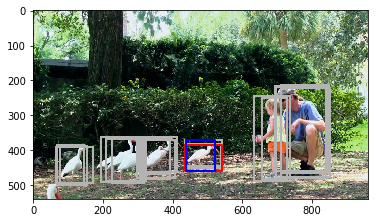

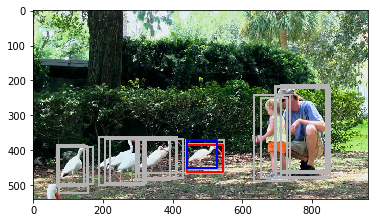

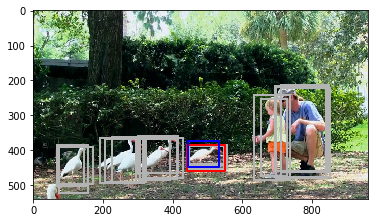

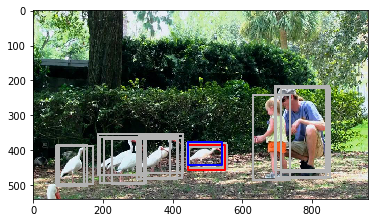

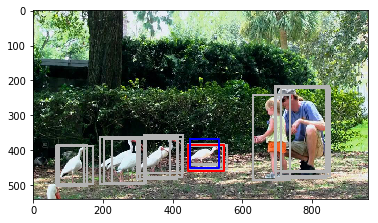

In [57]:
# save_plot_single("/home/zabulskyy/Datasets/vot2016/leaves/00000100.jpg",
#                  pr_path="/home/zabulskyy/Projects/CTU-Research/results/yolo-blind/leaves.txt",
#                  gt_path="/home/zabulskyy/Datasets/vot2016/leaves/groundtruth.txt",
#                  force_square=True, gt_idx=101, pr_idx=101)
cls = "birds2"
met = "descriptors/"
yolo_pred = "../yolo_predictions/extended/"

# save_plot_folder(osp.join("/home/zabulskyy/Datasets/vot2016", cls), saveto=osp.join("plots", met, cls),
#                  pr_path=osp.join("notebooks/" + met, cls) + ".csv",
#                  gt_path=osp.join(
#                      "/home/zabulskyy/Datasets/vot2016", cls, "groundtruth.txt"),
#                  force_square=True)

plot_everything(limit=5, imgs_folder=osp.join("/home/zabulskyy/Datasets/vot2016", cls), yolo_pred_file=osp.join(yolo_pred, cls+".csv"),
                    pred_file=osp.join("./" + met, cls) + ".csv", saveto="lololo",
                    force_square=True, gt_file=osp.join(
                     "/home/zabulskyy/Datasets/vot2016", cls, "groundtruth.txt"))


# save_plot_folder("/home/zabulskyy/Datasets/vot2016/leaves", saveto="./plots/yolo-first-smart-smart/leaves",
#                 pr_path="./results/yolo-first-smart-smart/leaves.txt",
#                 gt_path="/home/zabulskyy/Datasets/vot2016/leaves/groundtruth.txt",
#                 force_square=True)